In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

class Autoencoder(tf.keras.models.Model):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28,28,1)),
            tf.keras.layers.Dense(
                50,
                activation='relu',
                kernel_initializer=tf.keras.initializers.GlorotUniform()
            ),
            tf.keras.layers.Dense(
                bottleneck_dim,
                activation='relu',
                kernel_initializer=tf.keras.initializers.GlorotUniform()
            ),
        ])
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(
                28*28,
                activation='relu',
                kernel_initializer=tf.keras.initializers.GlorotUniform()
            ),
            tf.keras.layers.Reshape((28,28,1)),
        ])
    def call(self, x):
        return self.decoder(self.encoder(x))

ds, ds_info = tfds.load(
    'mnist',
    split='train',
    shuffle_files=True,
    batch_size=-1,
    with_info=True
)
ds['image'] = tf.cast(ds['image'], tf.float32) / 255.0

## Train autoencoder with bottleneck_dim = 2

In [32]:
# Setup autoencoder network with a bottleneck dim of 2
autoencoder2 = Autoencoder(2)

# Compile and fit model
learning_rate = 0.001
autoencoder2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss = 'mse',
)

autoencoder2.fit(
    x=ds['image'],
    y=ds['image'],
    verbose=0,
    shuffle=True,
    batch_size=8192,
    epochs=800,
)

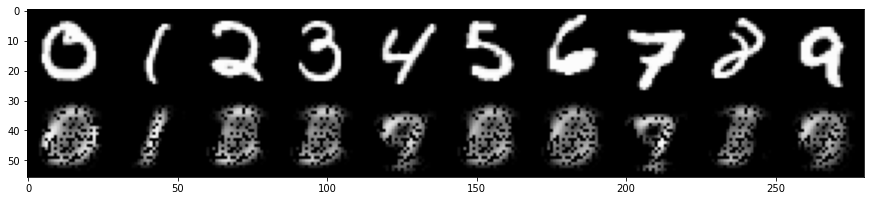

In [72]:
encoder2 = autoencoder2.encoder
decoder2 = autoencoder2.decoder

images = ds['image'].numpy()
labels = ds['label'].numpy()
decoded_images = autoencoder2(ds['image']).numpy()

image_examples = []
decoder_examples = []
# Pick random example from each label and merge
# to see how the autoencoder handles the different digits
for label in range(10):
    idx = np.random.choice(
        np.argwhere(labels==label).flatten()
    )
    image_examples.append(images[idx])
    decoder_examples.append(decoded_images[idx])
image_examples = np.concatenate(tuple(image_examples), axis=1)
decoder_examples = np.concatenate(tuple(decoder_examples), axis=1)

all_examples = np.concatenate((image_examples, decoder_examples), axis=0)

plt.figure(figsize=(15, 5))
plt.imshow(1-all_examples[:,:,0], cmap='Greys')

## Scatter well reproduced encoded digits

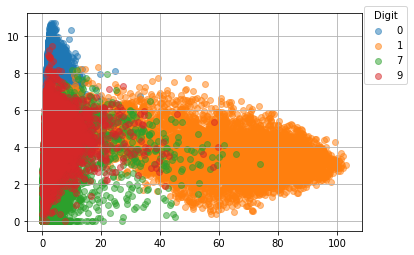

In [98]:
well_encoded_digits = [0, 1, 7, 9]

encoded_images = encoder2(ds['image']).numpy()
labels = ds['label'].numpy()

# Plot well reproduced images
fig, ax = plt.subplots()
for label in well_encoded_digits:
    img_idx = np.argwhere(labels == int(label))
    well_encoded_images = encoded_images[img_idx].reshape((-1, 2))
    ax.scatter(well_encoded_images[:,0], well_encoded_images[:,1], label=label, alpha=0.5)
ax.legend(loc="lower right", title="Digit", bbox_to_anchor=(1.15,0.65))
ax.grid()

## Scatter all digits

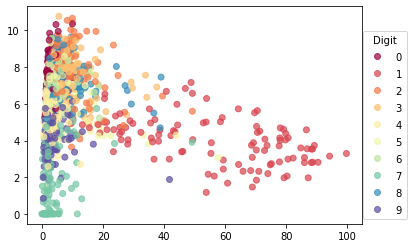

In [106]:
n_ex = 1000
fig, ax = plt.subplots()
scatter = ax.scatter(encoded_images[0:n_ex,0], encoded_images[0:n_ex,1], c=labels[0:n_ex], alpha=0.7, cmap='Spectral')
ax.legend(*scatter.legend_elements(), loc="lower right", title="Digit", bbox_to_anchor=(1.15,0.0))

## Reproduce digits

(28, 112, 1)


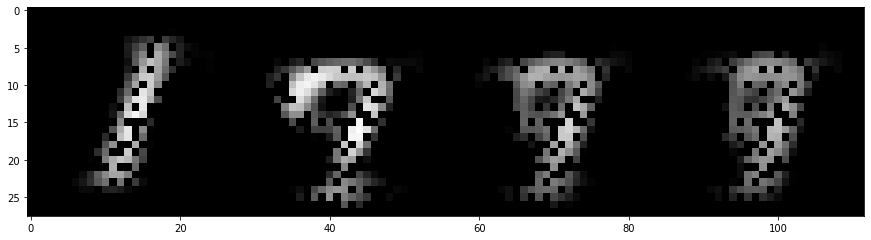

In [88]:
synthetic_encoded = np.array([
    [60, 4], # 1
    [0, 0], # 7
    [5, 3], # 9
    [8, 4], # 0
])
synthetic_decoded = decoder2(synthetic_encoded)
synthetic_decoded = [img for img in synthetic_decoded]
synthetic_decoded = np.concatenate(tuple(synthetic_decoded), axis=1)
plt.figure(figsize=(15, 5))
plt.imshow(1-synthetic_decoded[:,:,0], cmap='Greys')

## Train autoencoder with bottleneck_dim = 4

In [90]:
# Setup autoencoder network with a bottleneck dim of 2
autoencoder4 = Autoencoder(4)

# Compile and fit model
learning_rate = 0.001
autoencoder4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics='mse'
)

autoencoder4.fit(
    x=ds['image'],
    y=ds['image'],
    verbose=0,
    shuffle=True,
    batch_size=8192,
    epochs=800
)

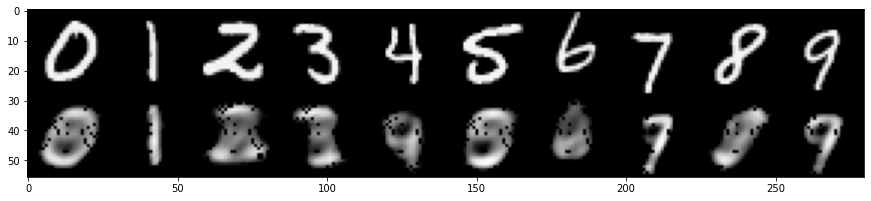

In [109]:
encoder4 = autoencoder4.encoder
decoder4 = autoencoder4.decoder

images = ds['image'].numpy()
labels = ds['label'].numpy()
decoded_images = autoencoder4(ds['image']).numpy()

image_examples = []
decoder_examples = []
# Pick random example from each label and merge
# to see how the autoencoder handles the different digits
for label in range(10):
    idx = np.random.choice(
        np.argwhere(labels==label).flatten()
    )
    image_examples.append(images[idx])
    decoder_examples.append(decoded_images[idx])
image_examples = np.concatenate(tuple(image_examples), axis=1)
decoder_examples = np.concatenate(tuple(decoder_examples), axis=1)

all_examples = np.concatenate((image_examples, decoder_examples), axis=0)

plt.figure(figsize=(15,5))
plt.imshow(1-all_examples[:,:,0], cmap='Greys')

## Find the rule for the well encoded digits in the second autoencoder

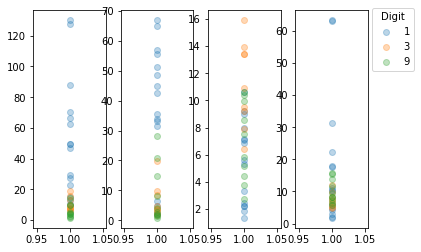

In [143]:
well_encoded_digits = [1, 3, 9]
n_ex = 100
encoded_images = encoder4(ds['image'][0:n_ex]).numpy()
labels = ds['label'][0:n_ex]

fig, axs = plt.subplots(1, 4)
for i, label in enumerate(well_encoded_digits):
    img_idx = np.argwhere(labels == int(label))
    dim = 0
    for ax in axs.flat:
        x = np.array([1 for j in img_idx])
        ax.scatter(x, encoded_images[img_idx,dim], alpha=0.3, label=label)
        dim += 1
plt.legend(loc="lower right", title="Digit", bbox_to_anchor=(1.7,0.7))

## Reproduce digit 1

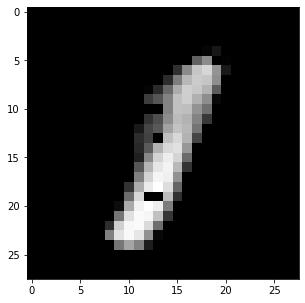

In [156]:
synthetic_encoded = np.array([
    [40, 60, 6, 10], # 1
])
synthetic_decoded = decoder4(synthetic_encoded)
synthetic_decoded = [img for img in synthetic_decoded]
synthetic_decoded = np.concatenate(tuple(synthetic_decoded), axis=1)
plt.figure(figsize=(15, 5))
plt.imshow(1-synthetic_decoded[:,:,0], cmap='Greys')